<a href="https://colab.research.google.com/github/SammyBrimberry/GoogleBigQuery_attritionClassification/blob/main/gbq_attrition_classificationV1_AP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [205]:
import pandas as pd
import numpy as np
import io
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE


In [ ]:
#access data locally 
# from google.colab import files
# uploaded = files.upload()
#df = pd.read_csv(io.BytesIO(uploaded['data.csv']))



Saving data.csv to data (3).csv


In [ ]:
# account authenticatio
from google.colab import auth
auth.authenticate_user()
print('Authenticated') # check

Authenticated


In [ ]:
# import biqguery, this is where our csv is living
from google.cloud import bigquery

# view settings
%load_ext google.colab.data_table

In [ ]:
# store project_id into object
project_id = 'civil-hope-323521'

In [ ]:
# init gbq client for specific cloud project
client = bigquery.Client(project=project_id)

In [206]:
# query our entire data living in google cloud
df = client.query('''
select * 
from `civil-hope-323521.attrition_dataset_1.IBM_attrition_2021` # project_id.database.table
''').to_dataframe()

df.head() # print out first 5 rows

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,48,False,Travel_Rarely,530,Sales,29,1,Medical,1,473,1,Female,91,3,3,Manager,3,Married,12504,23978,3,True,False,21,4,2,80,1,15,3,1,0,0,0,0
1,45,False,Travel_Frequently,364,Research & Development,25,3,Medical,1,1306,2,Female,83,3,5,Manager,2,Single,18061,13035,3,True,False,22,4,3,80,0,22,4,3,0,0,0,0
2,41,False,Travel_Rarely,896,Sales,6,3,Life Sciences,1,298,4,Female,75,3,3,Manager,4,Single,13591,14674,3,True,True,18,3,3,80,0,16,3,3,1,0,0,0
3,57,False,Travel_Rarely,210,Sales,29,3,Marketing,1,568,1,Male,56,2,4,Manager,4,Divorced,14118,22102,3,True,False,12,3,3,80,1,32,3,2,1,0,0,0
4,42,False,Travel_Rarely,265,Sales,5,2,Marketing,1,1029,4,Male,90,3,5,Manager,3,Married,18303,7770,6,True,False,13,3,2,80,0,21,3,4,1,0,0,0


The first step in understanding this data set is to understand the number of employees that have left the company. To do so, we can group the employees by attrition status and count the number of employees that fall into each category. Those numbers can be visualized in the bar graph below. 

Already, we can see that our data is imbalanced. A challenge for classification is to pay attention to balance and imbalance data, which will be explained shortly. 

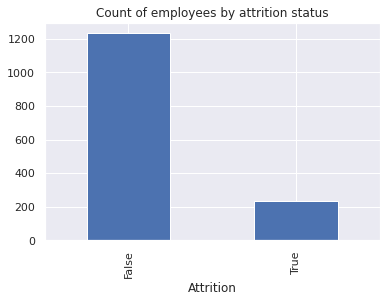

In [207]:
# count number of attrition
# imbalanced classification problem
df1 = df.groupby(['Attrition']).size() #this creates a new dataframe what groups the employees by attrition atatus and then provides a cont for the number in each group
#.reset_index(name='counts')
#plot the counts
df1.plot(kind='bar',title = "Count of employees by attrition status")


It is almost rare that all the variables in a dataset are useful to build a model and explain why some employees choose to leave over others. That being said, we want to start breaking down the data to understand if any particular set of features seem to be the key in explaining the variation in attrition. We can start by taking educated gueessed as to which features are most closely aligned with attrition.



In [208]:
# for i in df:
#     print(i)
#     print(df[i].unique())
#     print("#"*40)



We may start by looking at the average number of firms the employees of each of the two groups have been employed at over a period of time. To do so, we can group the data by attrition status and find the average number of past employmnets for each group. The graph below depicts the results. 


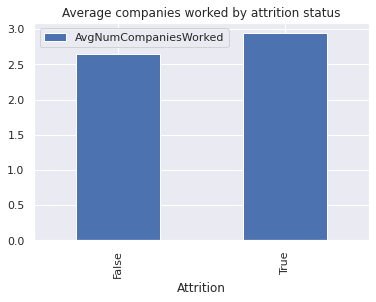

In [209]:
# roles by attrition status
df2 = df[["Attrition", "NumCompaniesWorked"]].rename(columns={"NumCompaniesWorked": "AvgNumCompaniesWorked"}).groupby(['Attrition']).mean()
df2.plot(kind='bar',title = "Average companies worked by attrition status")

	

From this bar graph it may be difficult to discern if the variation in number of past employments is related to the variation in attrition. While the avaergae number of past employments is higher for those that left, it is unclear how significant this difference is. Plotting the distribution will better explain the difference in variation. 

In [210]:
# px.scatter(df[["Attrition", "NumCompaniesWorked"]], x='NumCompaniesWorked', y="NumCompaniesWorked", size=1, color='Attrition')
# fg = seaborn.FacetGrid(data=df[["Attrition", "NumCompaniesWorked"]], hue='Attrition', aspect=1.61)
# fg.map(plt.scatter, 'NumCompaniesWorked', 'NumCompaniesWorked').add_legend()


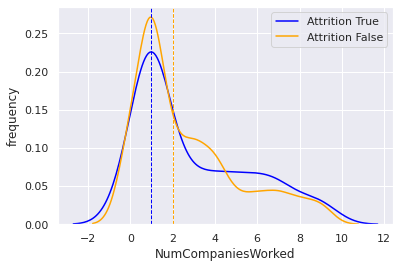

In [211]:
dfplot = df[["Attrition", "NumCompaniesWorked"]]
attrition_t = dfplot[dfplot["Attrition"]== True]
attrition_f = dfplot[dfplot["Attrition"]== False]

sns.set(color_codes=True)
sns.distplot(attrition_t["NumCompaniesWorked"], color="blue", hist=False, label="Attrition True")
sns.distplot(attrition_f["NumCompaniesWorked"], color="orange", hist=False, label="Attrition False")
plt.axvline(attrition_t["NumCompaniesWorked"].median(), color="blue", linestyle="dashed", linewidth=1)
plt.axvline(attrition_f["NumCompaniesWorked"].median(), color="orange", linestyle="dashed", linewidth=1)

plt.ylabel("frequency"),
plt.legend()

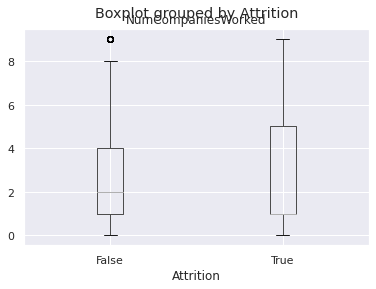

In [212]:
df.boxplot("NumCompaniesWorked", "Attrition")

From the two graphs above, we can see that the distributions and medians are quite similar across both groups. We can now do a similar visual analysis for other numerical features of interest. 

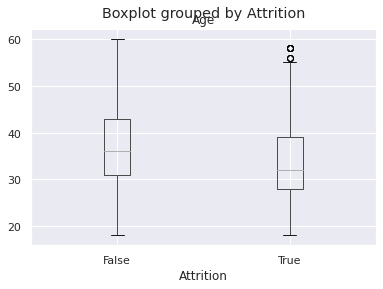

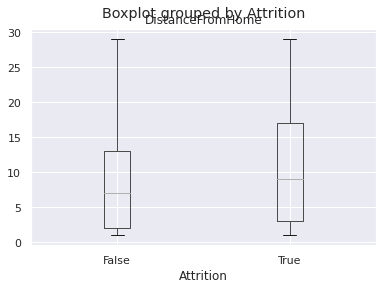

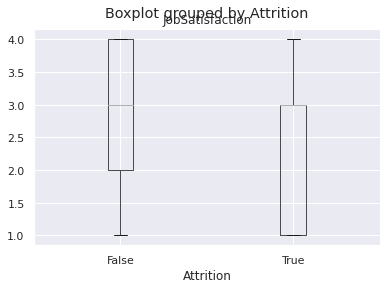

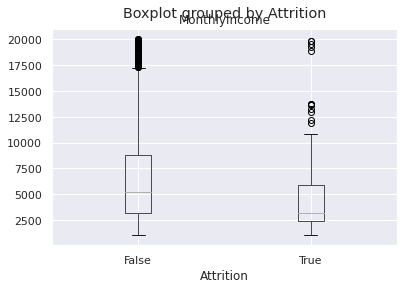

In [213]:
df.boxplot("Age", "Attrition")
df.boxplot("DistanceFromHome", "Attrition")
df.boxplot("JobSatisfaction", "Attrition")
df.boxplot("MonthlyIncome", "Attrition")

We could takeawy from these that younger people are more likely to leave their job. A greater DistanceFromHome, lower JobSatisfaction and lower MonthlyIncome may also influence attrition. 

 A Stacked Column chart will be more useful to visualize the relationship between two categorical variables. It compares the percentage that each category from one variable contributes to a total across categories of the second variable.

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


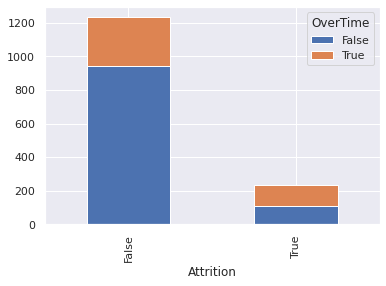

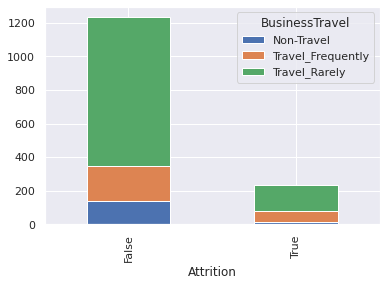

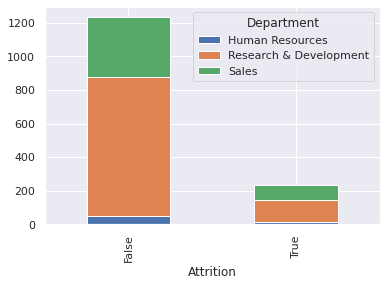

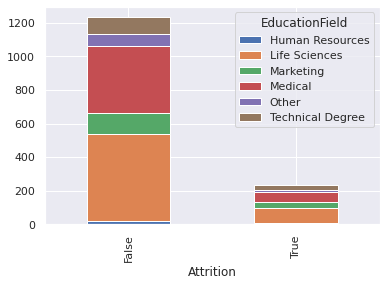

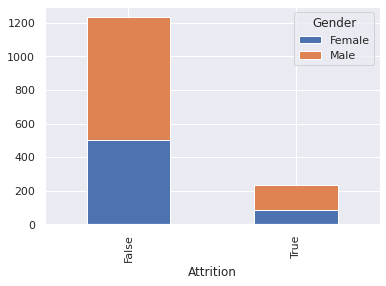

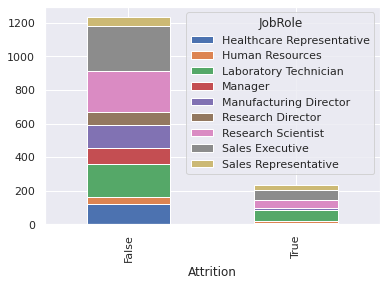

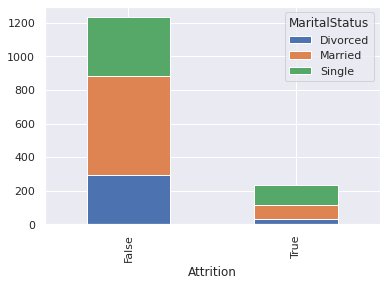

In [214]:
cat = ["OverTime", 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']
for x in cat:
  df_new = df.groupby(["Attrition", x])[x].count().unstack().plot(kind = "bar", stacked = True)
  print(df_new)

From the Grpahs above, we can start seeing that the rate of over time is much higher in the attrition group then the non attrition group. The rate of singles is much higher in attrition as well. Employees who travel often seem to be affected more often from attrition. From these grpahs, it looks like gender is not related to Attrition. 

It is also important to note and discard the few features with absolutely no variation between groups. "Over18", "EmployeeCount", and "StandardHours" have only one value, thus they will definitely not expalin any of the variation in atrition. 

EmployeeNumber can also be dropped for now, as it represents a unique identifier for each employee.





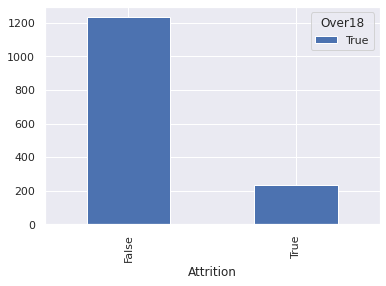

In [215]:
  df_new = df.groupby(["Attrition", "Over18"])["Over18"].count().unstack().plot(kind = "bar", stacked = True)


In [216]:
#drop the columns that won't be relvent to prediction
df_drop = df
df_drop.drop(columns = {"Over18", "EmployeeCount", "EmployeeNumber", "StandardHours"}, inplace = True)


In [217]:
df_drop.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,48,False,Travel_Rarely,530,Sales,29,1,Medical,1,Female,91,3,3,Manager,3,Married,12504,23978,3,False,21,4,2,1,15,3,1,0,0,0,0
1,45,False,Travel_Frequently,364,Research & Development,25,3,Medical,2,Female,83,3,5,Manager,2,Single,18061,13035,3,False,22,4,3,0,22,4,3,0,0,0,0
2,41,False,Travel_Rarely,896,Sales,6,3,Life Sciences,4,Female,75,3,3,Manager,4,Single,13591,14674,3,True,18,3,3,0,16,3,3,1,0,0,0
3,57,False,Travel_Rarely,210,Sales,29,3,Marketing,1,Male,56,2,4,Manager,4,Divorced,14118,22102,3,False,12,3,3,1,32,3,2,1,0,0,0
4,42,False,Travel_Rarely,265,Sales,5,2,Marketing,4,Male,90,3,5,Manager,3,Married,18303,7770,6,False,13,3,2,0,21,3,4,1,0,0,0


#Logistic Regression - Basic Classification 

In [218]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix

from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids

In [219]:
df_drop.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,48,False,Travel_Rarely,530,Sales,29,1,Medical,1,Female,91,3,3,Manager,3,Married,12504,23978,3,False,21,4,2,1,15,3,1,0,0,0,0
1,45,False,Travel_Frequently,364,Research & Development,25,3,Medical,2,Female,83,3,5,Manager,2,Single,18061,13035,3,False,22,4,3,0,22,4,3,0,0,0,0
2,41,False,Travel_Rarely,896,Sales,6,3,Life Sciences,4,Female,75,3,3,Manager,4,Single,13591,14674,3,True,18,3,3,0,16,3,3,1,0,0,0
3,57,False,Travel_Rarely,210,Sales,29,3,Marketing,1,Male,56,2,4,Manager,4,Divorced,14118,22102,3,False,12,3,3,1,32,3,2,1,0,0,0
4,42,False,Travel_Rarely,265,Sales,5,2,Marketing,4,Male,90,3,5,Manager,3,Married,18303,7770,6,False,13,3,2,0,21,3,4,1,0,0,0


In [220]:
df_drop.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')

The first step in a classification problem is to seperate categorical and numerical features. Typically this can be done by assuming all data with with "String" as its type is categorical and all data with integers as its type is numerical. However, in this case, some of the numerical data is really on a likert scale. (Data on a likert scale can either been seen as categorical or numerican due to the ordered nature of the categories). However, some of the numerical data are true categorical features with no intervall or true zero (Education etc.). In these cases, we can decide how to hand each feature. All categorical data needs to be dummy encoded (when only two categories exist) or one hot encoded (when multiple categories exist). 

In [221]:
# define features
df_copy = df_drop


#X=df_copy.drop(columns=['Attrition"])
#X = pd.get_dummies(X)- this would work because it knos to only convert strings, but some of our categorical data is numeric

#if we dont treak likert as categorical, we can do this
numerical = df_copy.dtypes[df_copy.dtypes != "object"].index
categorical = df_copy.dtypes[df_copy.dtypes== "object"].index
# Cat = categorical.tolist()

numerical = df_copy[["Age", "DailyRate", "DistanceFromHome","HourlyRate", "MonthlyIncome", 'MonthlyRate', 'NumCompaniesWorked',
        'PercentSalaryHike',
       'TotalWorkingYears', 'TrainingTimesLastYear', 
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager']]

categorical = df_copy[['BusinessTravel', 'Department', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'OverTime', 'PerformanceRating',
       'RelationshipSatisfaction', 'StockOptionLevel','WorkLifeBalance']].astype(str)
categorical = pd.get_dummies(categorical, drop_first=True) #dropping a category within each feature is important to prevent multicolliniarity
X = categorical.merge(numerical, left_index=True, right_index=True)
X_copy = X
X_copy_2 = X


In [222]:
#another way to encode
df_encoded = pd.get_dummies(data = df_copy, columns = ["Attrition", 'BusinessTravel', 'Department', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'OverTime', 'PerformanceRating',
       'RelationshipSatisfaction', 'StockOptionLevel','WorkLifeBalance'], drop_first=True)

df_encoded.head()

,Age,DailyRate,DistanceFromHome,HourlyRate,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition_True,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,Education_2,Education_3,Education_4,Education_5,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,EnvironmentSatisfaction_2,EnvironmentSatisfaction_3,EnvironmentSatisfaction_4,Gender_Male,JobInvolvement_2,JobInvolvement_3,JobInvolvement_4,JobLevel_2,JobLevel_3,JobLevel_4,JobLevel_5,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,JobSatisfaction_2,JobSatisfaction_3,JobSatisfaction_4,MaritalStatus_Married,MaritalStatus_Single,OverTime_True,PerformanceRating_4,RelationshipSatisfaction_2,RelationshipSatisfaction_3,RelationshipSatisfaction_4,StockOptionLevel_1,StockOptionLevel_2,StockOptionLevel_3,WorkLifeBalance_2,WorkLifeBalance_3,WorkLifeBalance_4
0,48,530,29,91,12504,23978,3,21,15,3,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,0
1,45,364,25,83,18061,13035,3,22,22,4,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0
2,41,896,6,75,13591,14674,3,18,16,3,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,1,0
3,57,210,29,56,14118,22102,3,12,32,3,1,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0
4,42,265,5,90,18303,7770,6,13,21,3,1,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1


In [223]:
# X.describe()

In [224]:

# set target
target = ['Attrition'] # we want to predict this value
y = df_copy.loc[:, target].copy()

y['Attrition'].value_counts() # same as count above

False    1233
True      237
Name: Attrition, dtype: int64

The next step is to implement the train-test split procedure. This is a mechanism used to estimate the performance of machine learning algorithms. The training data is used to build the algorithm and the testing data is used to measure the performance of the algorithm. It is important to set aside testing data, otherwise the model will be build around all your data and surely overfit it. 



In [225]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=41)

We will not fit a simple logistic regression 

In [226]:
model = LogisticRegression(solver='lbfgs',random_state=42)#setting up the regression
model.fit(X_train,y_train)#fitting the regression to the training data
target_predictions = model.predict(X_test)#using the model to make predictions on the testing data


#Accuracy - Basic Logistic Regression

We now want to judge the accuracy of our model by comparing the predicted results with the test data we put aside. A balanced accuracy score takes into account the fact that our data is imbalanced (comtains much few datapoints where attrition is true)

In [227]:
balanced_accuracy_score(y_test, target_predictions)

0.5

In [228]:
accuracy_score(y_test, target_predictions)

0.8097826086956522

We can see that the accuracy score is much higher (better) then the balanced score due to the large class imbalance. Accuracy is defined as the correct predictions/total number of data points. When there is a class imbalance, the model is likely overfitting. 

A confusion matrix is another way of visualizing the results of a classification problem. Because classification accuracy alone can be misleading if you have an unequal number of observations in each group, a confusion matrix can give you a better idea of what your classification model is getting right and what types of errors it is making. (TP, TN, FP, FN). Using this breakdown, we can also use other metrics to better define the accuracy. Percision and recall. 



In [229]:
confusion_matrix(y_test, target_predictions)

array([[298,   0],
       [ 70,   0]])

Precision and recall

#Logistic Regression - Standardize data

One tool for optimizing accuracy when running a logistic regression is to standardize data. Standardizing the data is not always needed in logistic regression, but it prevents features with naturally higher magnitudes from seeming explain more of the target then they actually do. 

In [230]:


X_copy = pd.DataFrame(StandardScaler().fit_transform(X_copy), columns = X_copy.columns)
X_train, X_test, y_train, y_test = train_test_split(X_copy,y,random_state=41)
model = LogisticRegression(solver='lbfgs',random_state=42)
model.fit(X_train,y_train)
target_predictions = model.predict(X_test)
balanced_accuracy_score(y_test, target_predictions)



0.7424736337488016

In [231]:
accuracy_score(y_test, target_predictions)


0.875

We can see that the balanced accuracy went up. Again, the imbalanced accuracy score is misleadingly higher for the same reasons as before. 

#SMOTE for imbalanced classification

As we saw from the confusion matrix based on the simple and standardized logistic regression, the models have poor performance on the minority class. SMOTE is an approach to addressing imbalanced datasets by oversampling the minority class. Once we augment the dataset, we can rerun the logistic regression. 



In [232]:
df_encoded.shape

(1470, 63)

In [233]:
X_copy.shape

(1470, 62)

In [258]:
sm = SMOTE(sampling_strategy= "minority", random_state=10)

x_art, y_art = sm.fit_sample(df_encoded.drop(columns="Attrition_True"), df_encoded["Attrition_True"])

artificaldf = pd.concat([pd.DataFrame(x_art), pd.DataFrame(y_art)], axis=1)
cols = df_encoded.columns.tolist()
cols.remove("Attrition_True")
cols.append("Attrition_True")
artificaldf.columns = cols

# fig, ax = plt.subplots(figsize = (10,10))
# ax = sns.heatmap(artificaldf.corr())
# ax.set_title("Correlation after SMOTE")
# plt.show

In [262]:
#Show how SMOTE balances data
print(artificaldf.shape)
artificaldf["Attrition_True"].value_counts()



(2466, 63)


1    1233
0    1233
Name: Attrition_True, dtype: int64

#Logistic Regression - on standardized, SMOTE oversampled data

Standardize data again, this time also oversample the data with target values as well (SMOTE)

In [264]:
X = df_encoded.drop(columns={"Attrition_True"})
y = df_encoded["Attrition_True"]

In [265]:
X = pd.DataFrame(StandardScaler().fit_transform(X), columns = X.columns)


In [266]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=7, stratify = y, test_size = .15)

In [267]:

xtrainover, y_trainover = sm.fit_sample(X_train, y_train)

In [268]:
print("Size of trainval:{}\nSize of test:{}".format(xtrainover.shape, X_test.shape))


Size of trainval:(2096, 62)
Size of test:(221, 62)


In [269]:
model.fit(xtrainover, y_trainover)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [270]:
SMOTE_oversampling_predictions = model.predict(X_test)


In [271]:
balanced_accuracy_score(y_test, SMOTE_oversampling_predictions)

0.7364114114114114

In [272]:
accuracy_score(y_test, SMOTE_oversampling_predictions)

0.7647058823529411

We can see now that accuracy rose for the balanced socre and it is now very close to the accuracy score.

#Feature Selection - to increase accuracy


In [273]:
feature_importance_LR = pd.DataFrame(dict(Column = np.hstack(np.array([X.columns])), Importance = np.hstack(model.coef_))).sort_values(by = "Importance", ascending = False)
# feature_importance_LR.to_csv('feature_importance.csv', index=False) 
# files.download('feature_importance.csv')

feature_importance_LR

# feature_importance_LR.to_csv("drive/My Drive/Python_Tutorial/feature_importance.csv")
# !cp feature_importance.csv "drive/My Drive/Python_Tutorial"



,Column,Importance
10,YearsAtCompany,1.134735
51,OverTime_True,1.066583
14,BusinessTravel_Travel_Frequently,1.032562
44,JobRole_Sales Executive,0.991167
16,Department_Research & Development,0.906977
...,...,...
32,JobInvolvement_3,-0.749748
34,JobLevel_2,-0.785458
48,JobSatisfaction_4,-0.838044
29,EnvironmentSatisfaction_4,-0.855899


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text major ticklabel objects>)

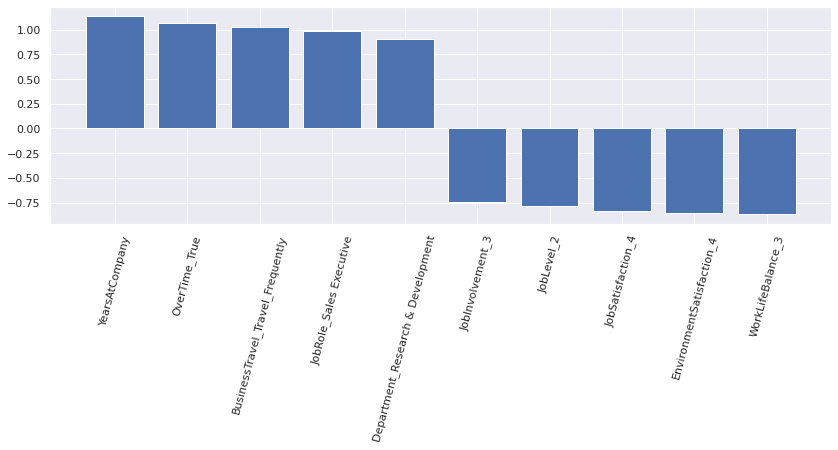

In [274]:
fig = plt.figure(figsize = (14,4))
plt.bar(x = pd.concat([feature_importance_LR.iloc[:5,0],feature_importance_LR.iloc[-5:,0]]), height = pd.concat([feature_importance_LR.iloc[:5,1],feature_importance_LR.iloc[-5:,1]]))
plt.xticks(rotation = 75)

In [279]:
#dont do feature importance 

xtrainover_df = pd.DataFrame(xtrainover)
xtrainover_df.columns = X_train.columns

small_xtrain = xtrainover_df[["OverTime_True", "JobRole_Sales Executive", "BusinessTravel_Travel_Frequently", "BusinessTravel_Travel_Rarely", "JobRole_Sales Representative", "JobRole_Laboratory Technician", "DistanceFromHome"]]
small_xtest = X_test[["OverTime_True", "JobRole_Sales Executive", "BusinessTravel_Travel_Frequently", "BusinessTravel_Travel_Rarely", "JobRole_Sales Representative", "JobRole_Laboratory Technician", "DistanceFromHome"]]
model.fit(small_xtrain, y_trainover)
pred = model.predict(small_xtest)
balanced_accuracy_score(y_test, pred)



0.6626876876876877

# Feature Engineering - for better accruacy (SVD/PCA) 

In [284]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5, svd_solver='full')
new_x = pca.fit(xtrainover_df)


In [285]:
new_x

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
    svd_solver='full', tol=0.0, whiten=False)